In [2]:
import pandas as pd
from nltk.stem import PorterStemmer
from nltk import word_tokenize

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Nmf

import utils

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
stemmer = PorterStemmer()

In [5]:
tdf = pd.read_csv('transcripts/transcripts.csv')
tdf_g = pd.read_csv('speaker_grouped.csv')

In [6]:
tdf['tokens'] = tdf['content'].apply(lambda x : utils.process(x, stemmer=stemmer)) 

In [7]:
texts = tdf['tokens'].tolist()

In [8]:
dictionary = Dictionary(texts)

corpus = [dictionary.doc2bow(text) for text in texts]

### EVENTUALLY USE MORE SOPHISTICATED PROCEDURE TO SELECT NUMBER OF TOPICS

In [9]:
ldamodel = LdaModel(corpus, num_topics=40, id2word=dictionary, passes=5, random_state=0, minimum_probability=0)

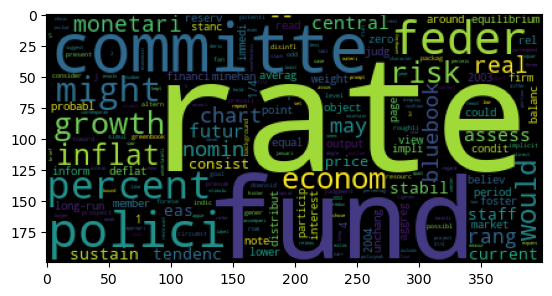

In [49]:
plt.imshow(WordCloud().fit_words(dict(ldamodel.show_topic(39, 200))))

In [ ]:
for i in range(45):
    print(nmf.show_topic(i, 10)[0:5])
    print('\n')

In [487]:
def get_max_topic(tokens):
    topic_probs = nmf[dictionary.doc2bow(tokens)]
    if len(topic_probs) > 0:
        max_prob = topic_probs[0][1]
        max_ind = 0
        for i in range(1, len(topic_probs)):
            if topic_probs[i][1] > max_prob:
                max_prob = topic_probs[i][1]
                max_ind = i
        return pd.Series([topic_probs[max_ind][0], max_prob], index=['topic', 'prob'])
    return pd.Series([None, None], index=['topic', 'prob'])

get_max_topic(tdf.loc[205].tokens)

[(0, 0.22982931844332238), (3, 0.006064672707542939), (4, 0.00411476679532423), (5, 0.31380085446080264), (6, 0.10521444370169349), (9, 0.0007210869601999902), (18, 0.21149594909681899), (19, 0.014213836399375282), (20, 0.003915786899366396), (23, 0.0019623029518893373), (25, 0.029323307179473786), (32, 0.0017333808246226285), (33, 0.06890445417181804), (35, 0.006816483192542763), (41, 0.0018893562152070187)]


topic    5.000000
prob     0.313801
dtype: float64

In [18]:
def get_all_topics(tokens):
    topic_probs = ldamodel[dictionary.doc2bow(tokens)]
    result = [0] * 45
    for topic, prob in topic_probs:
        result[topic] = prob
    return pd.Series(result)

In [56]:
tdf[[f'tprob_{i}' for i in range(45)]] = tdf.tokens.apply(get_all_topics)

<Axes: xlabel='date'>

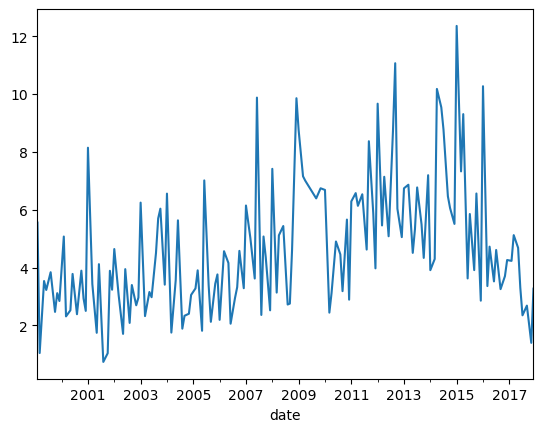

In [587]:
mtdf = tdf[tdf['type'] == 'meeting'] 
mtdf[['tprob_35', 'date']].groupby(pd.PeriodIndex(mtdf['date'], freq='M'))['tprob_35'].sum().plot()

In [472]:
tdf_sample = tdf.sample(5000)

In [473]:
tdf_sample[['topic','topic_prob']] = tdf_sample.tokens.apply(get_topics)

In [479]:
tdf_sample[tdf_sample['topic'] == 5][['content', 'topic_prob']].to_csv('topictest.csv')

In [201]:
sdf[['topic', 'topic_prob']] = sdf.tokens.apply(get_topics)

In [202]:
tdf[['topic', 'topic_prob']] = tdf.tokens.apply(get_topics)

In [ ]:
for item in sdf[sdf['topic'] == 6.0]['text'][:25]:
    print(item)

In [209]:
path = "Loughran-McDonald_MasterDictionary_1993-2021.csv"

lm_df = pd.read_csv(path)

lm = {}

for i, row in lm_df.iterrows():
    # print(row)
    word = str(row['Word']).lower()
    if row['Negative'] != 0:
        lm[word] = -1
    if row['Positive'] != 0:
        lm[word] = 1

In [219]:
def sentscore(string):
    # tokens = process(string)
    total = 0
    tokens = [token.lower() for token in word_tokenize(str(string))]
    numtokens = len(tokens) if len(tokens) > 0 else 1
    for token in tokens:
        # print(token)
        if token in lm:
            total += lm[token]
            # print(token)
            # print(lm[token])
    # print(total)
    # print(tokens)
    return total

In [220]:
tdf['lm_sent'] = tdf['content'].apply(sentscore)

In [221]:
sdf['lm_sent'] = sdf['text'].apply(sentscore)

In [225]:
speech_infl = sdf[sdf['topic'] == 9][['date', 'lm_sent']]
speech_infl['date'] = pd.to_datetime(speech_infl['date'])
sinfdf = speech_infl.groupby(pd.PeriodIndex(speech_infl['date'], freq='M'))['lm_sent'].sum()

In [229]:
transcript_infl = tdf[tdf['topic'] == 9][['date', 'lm_sent']]
transcript_infl['date'] = pd.to_datetime(transcript_infl['date'])
tinfdf = transcript_infl.groupby(pd.PeriodIndex(transcript_infl['date'], freq='M'))['lm_sent'].sum()

In [236]:
speech_grow = sdf[sdf['topic'] == 37][['date', 'lm_sent']]
speech_grow['date'] = pd.to_datetime(speech_grow['date'])
sgrowdf = speech_grow.groupby(pd.PeriodIndex(speech_grow['date'], freq='M'))['lm_sent'].sum()

In [237]:
transcript_grow = tdf[tdf['topic'] == 37][['date', 'lm_sent']]
transcript_grow['date'] = pd.to_datetime(transcript_grow['date'])
tgrowdf = transcript_grow.groupby(pd.PeriodIndex(transcript_grow['date'], freq='M'))['lm_sent'].sum()

<Axes: xlabel='date'>

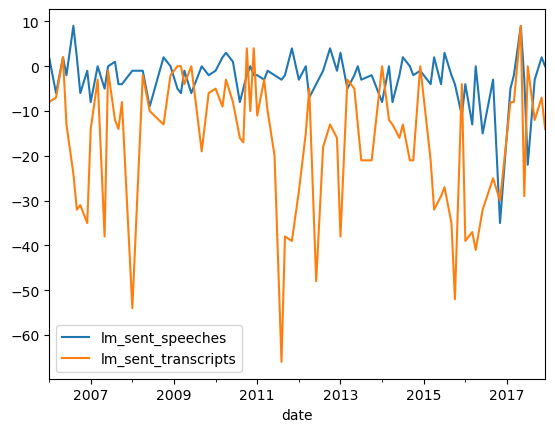

In [227]:
merged_inf = pd.merge(sinfdf, tinfdf, on='date', suffixes=['_speeches', '_transcripts'])
merged_inf.plot()
# merged_inf

<Axes: xlabel='date'>

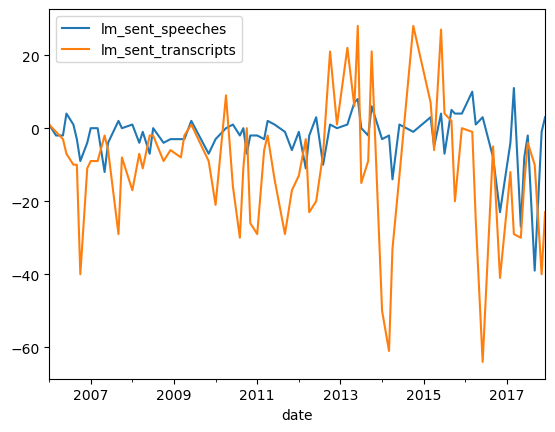

In [238]:
merged_grow = pd.merge(sgrowdf, tgrowdf, on='date', suffixes=['_speeches', '_transcripts'])
merged_grow.plot()